### Importing The Required Libraries:

In [1]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np

from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


tf.__version__
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5



In [2]:
filename = "all4"
tokenizer = pickle.load(open('tokenizer/tokenizer-' + filename + '.pkl', 'rb'))


In [3]:
file = open("data/" + filename + "-cleaned.txt", "r", encoding = "utf8")
data = file.readlines()[0]
data[:100]

'of the Phoenician alphabet the equivalent of the Hebrew Aleph and itself from the Egyptian origin Th'

In [10]:
def seq():
    sequence_data = tokenizer.texts_to_sequences([data])[0]
    sequence_data[:10]

    vocab_size = len(tokenizer.word_index) + 1

    sequences = []
    for i in range(1, len(sequence_data)):        
        words = sequence_data[i-1:i+1]
        sequences.append(words)

    sequence = np.array(sequences)
    return sequence, vocab_size

In [5]:
def defieData():
    sequence = seq()
    X = []
    Y = []

    for i in sequence:
        X.append(i[0])
        Y.append(i[1])

    X = np.array(X)
    Y = np.array(Y)

    Y = to_categorical(Y, num_classes=vocab_size)
    return X,Y

In [11]:
i,vocab_size = seq()
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             427900    
_________________________________________________________________
lstm (LSTM)                  (None, 1, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 42790)             42832790  
Total params: 56,309,690
Trainable params: 56,309,690
Non-trainable params: 0
_________________________________________________________________


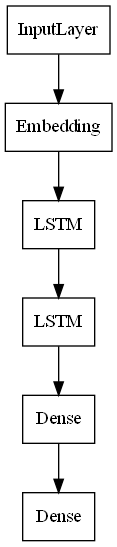

In [12]:
from tensorflow import keras
from tensorflow.keras.utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=False)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword-"+filename+".h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword'+filename
tensorboard_Visualization = TensorBoard(log_dir=logdir)

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))

In [14]:
X,Y = defieData()
print(X,Y)

TypeError: 'int' object is not subscriptable

In [9]:

model.fit(X, Y, epochs=200, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])


Epoch 1/200
666/666 [==============================] - 11s 10ms/step - loss: 6.5033

Epoch 00001: loss improved from inf to 6.50333, saving model to nextword-qa-1M.h5
Epoch 2/200
666/666 [==============================] - 6s 9ms/step - loss: 5.9988

Epoch 00002: loss improved from 6.50333 to 5.99884, saving model to nextword-qa-1M.h5
Epoch 3/200
666/666 [==============================] - 6s 9ms/step - loss: 5.6136

Epoch 00003: loss improved from 5.99884 to 5.61364, saving model to nextword-qa-1M.h5
Epoch 4/200
666/666 [==============================] - 6s 9ms/step - loss: 5.3482

Epoch 00004: loss improved from 5.61364 to 5.34816, saving model to nextword-qa-1M.h5
Epoch 5/200
666/666 [==============================] - 6s 9ms/step - loss: 5.1422

Epoch 00005: loss improved from 5.34816 to 5.14218, saving model to nextword-qa-1M.h5
Epoch 6/200
666/666 [==============================] - 6s 9ms/step - loss: 4.9611

Epoch 00006: loss improved from 5.14218 to 4.96114, saving model to nextwo

Epoch 98/200
666/666 [==============================] - 6s 9ms/step - loss: 3.1891

Epoch 00098: loss improved from 3.18951 to 3.18911, saving model to nextword-qa-1M.h5
Epoch 99/200
666/666 [==============================] - 6s 9ms/step - loss: 3.1865

Epoch 00099: loss improved from 3.18911 to 3.18650, saving model to nextword-qa-1M.h5
Epoch 100/200
666/666 [==============================] - 6s 9ms/step - loss: 3.1870

Epoch 00100: loss did not improve from 3.18650
Epoch 101/200
666/666 [==============================] - 6s 9ms/step - loss: 3.1866

Epoch 00101: loss did not improve from 3.18650
Epoch 102/200
666/666 [==============================] - 6s 9ms/step - loss: 3.1844

Epoch 00102: loss improved from 3.18650 to 3.18441, saving model to nextword-qa-1M.h5
Epoch 103/200
666/666 [==============================] - 6s 9ms/step - loss: 3.1826

Epoch 00103: loss improved from 3.18441 to 3.18262, saving model to nextword-qa-1M.h5
Epoch 104/200
666/666 [==============================]

666/666 [==============================] - 6s 9ms/step - loss: 3.0548

Epoch 00200: loss improved from 3.05503 to 3.05480, saving model to nextword-qa-1M.h5


In [10]:
# https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
# tensorboard --logdir="./logsnextword1"
# http://DESKTOP-U3TSCVT:6006/

from IPython.display import Image 
pil_img = Image(filename='graph1.png')
display(pil_img)

In [17]:
def Predict_Next_Words(model, tokenizer, text):
    #print(text)
    arr = []
    arr.append(text)
    sequence = tokenizer.texts_to_sequences([text])[0]
    
    sequence = np.array(sequence)
    print(sequence)
    res = []
    preds = model.predict(sequence)
    #print(preds)
    preds1= np.flip(np.argsort(preds,axis=1))
    preds = np.argmax(preds,axis=1)
    for i in range(10):
        res.append((preds1[0][i]))
    #print(len(res))
    predicted_word = ""
    predicted_words = []

    for key, value in tokenizer.word_index.items():
        if value in res:
            predicted_words.append(key)
            #print(key)
            #break

    #print(len(predicted_word))
    return predicted_words

In [18]:
strs = ["All","And","Boy","Book","Call","Car","Chair","Children","City","Dog","Door","Enemy","End","Enough","Eat","Friend","Father","Go","Good","Girl","Food","Hear","House","Inside","Laugh","Listen","Man","Name","Never","Next","New","Noise","Often","Pair","Pick","Play","Room","See","Sell","Sit","Speak","Smile","Sister","Think","Then","Walk","Water","Work","Write","Woman","Yes"]

for i in range(50):
    export = Predict_Next_Words(model, tokenizer, strs[i])
    print(strs[i] + "\t" + "\t".join(export))

[462]
All	the	so	those	of	about	that	i	he	bearded	time
[601]
And	they	the	a	then	was	it	that	i	you	he
[3160]
Boy	did	actor	as	at	too	like	i	in	from	to
[4372]
Book	have	so	of	because	with	in	artist	market	shelf	legend
[4183]
Call	they	the	new	of	it	i	and	he	backs	playing
[]


ValueError: Expect x to be a non-empty array or dataset.